In [126]:

! pip -q install pytorch_lightning transformers wandb sentence-transformers

In [127]:
! pip install -q tfds-nightly tensorflow matplotlib

In [128]:
!pip install datasets

In [129]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import re
import math
import gc
from tqdm.notebook import tqdm_notebook
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

import pytorch_lightning as pl
import pytorch_lightning
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

device =  torch.device('cuda' if torch.has_cuda else 'cpu')
device

device(type='cuda')

In [130]:
!nvidia-smi

Fri Jun 30 10:18:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    40W / 300W |   1300MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Dataset and pre-trained weights

In [131]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
dir = f"huggingface:code_search_net/python/"
dir

'huggingface:code_search_net/python/'

In [134]:
path = '/content/'

In [135]:
def getDataframe(filepath, spl):
    print(filepath+spl)
    ds = tfds.load(filepath, split=spl, shuffle_files=True)
    assert isinstance(ds, tf.data.Dataset)

    # rawData = []

    # for index, key in enumerate(data):
        # temp = [key['func_code_tokens'],key['func_documentation_tokens'],key['func_code_string'], key['func_documentation_string']]
        # temp = [list(tf.cast(key['func_code_tokens'], dtype=string)), list(tf.cast(key['func_documentation_tokens'], dtype=string))]
        # temp = [list(key['func_code_tokens'].numpy().astype('str')),
        #         list(key['func_documentation_tokens'].numpy().astype('str')),
        #         key['func_code_string'].numpy(),
        #         key['func_documentation_string'].numpy()]
        # temp = [list(key['func_code_tokens'].numpy().astype('str')), list(key['func_documentation_tokens'].numpy().astype('str'))]
        # temp = key['func_documentation_string'].numpy()
        # temp = key['func_code_string'].numpy()
        # temp = [key['func_code_string'].numpy(),
        #         key['func_documentation_string'].numpy()]
        # rawData.append(temp)
        # if index >=50:
        #     break
    # df = pd.DataFrame(rawData)

    return ds

In [136]:
# ds = tfds.load(dir, split='spl', shuffle_files=True)

In [137]:
trainds = getDataframe('huggingface:code_search_net/python', spl='train')
testds = getDataframe('huggingface:code_search_net/python', spl='test')
validds = getDataframe('huggingface:code_search_net/python', spl='validation')

huggingface:code_search_net/pythontrain
huggingface:code_search_net/pythontest
huggingface:code_search_net/pythonvalidation


In [138]:
def convertTensor2dataframe(ds):
    list = []
    for index, key in enumerate(ds):
        temp = []
        temp = [key['func_code_string'].numpy().decode(), key['func_documentation_string'].numpy().decode()]
        list.append(temp)

    return pd.DataFrame(list, columns=['code','docstring'])


In [125]:
train = convertTensor2dataframe(trainds)
test = convertTensor2dataframe(testds)
valid = convertTensor2dataframe(validds)

In [139]:
# Rename the 'B' and 'C' columns
# train = train.rename(columns={0: 'code', 1: 'docstring'})
# valid = valid.rename(columns={0: 'code', 1: 'docstring'})
# test = test.rename(columns={0: 'code', 1: 'docstring'})

In [140]:
train

,code,docstring
0,"def verify_state(global_state_db, blockstore, ...",Verify the state root hash of all blocks is in...
1,"def get_beatmaps(self, *, since=None, beatmaps...",Get beatmaps.\n\n Parameters\n -...
2,"def rover_lat_accel(VFR_HUD, SERVO_OUTPUT_RAW)...",return lateral acceleration in m/s/s
3,"def _voltage_angle_diff_limit(self, buses, bra...",Returns the constraint on the branch voltage a...
4,"def _check_type(name, obj, expected_type):\n ...",Raise a TypeError if object is not of expected...
...,...,...
412173,"def reset_obscov(self,arg=None):\n """"""r...",reset the obscov attribute to None\n\n ...
412174,"def copy(self):\n """"""\n Returns ...",Returns a copy of the TabularCPD object.\n\n ...
412175,"def Extra(self):\n """"""\n Returns...","Returns any `V`, `P`, `DOI` or `misc` values a..."
412176,"def write(self, file_or_filename):\n """"...",Writes case data to file in Excel format.


In [141]:
valid

,code,docstring
0,"def RunScriptAsAdmin(argv: list, workingDirect...",Run a python script as administrator.\n Sys...
1,"def get_player_battles(self, *tags: crtag, **p...",Get a player's battle log\n\n Parameter...
2,"def pointwise_product(self, other, bn):\n ...","Multiply two factors, combining their variables."
3,"def convergent_round(value, ndigits=0):\n ""...",Convergent rounding.\n\n Round to neareas e...
4,"def compare_token(expected: Union[str, bytes],...",Compares the given tokens.\n\n :param expec...
...,...,...
23102,"def WheelDown(self, wheelTimes: int = 1, inter...","Make control have focus first, move cursor to ..."
23103,"def unlock(self, pwd):\n """""" Unlock the...",Unlock the wallet database
23104,"def fromutc(self, dt):\n """"""\n G...",Given a timezone-aware datetime in a given tim...
23105,"def _getnodenamefor(self, name):\n ""Ret...",Return the node name where the ``name`` would ...


In [142]:
train = train.loc[1:80000]
valid = valid.loc[1:20000]
test = test.loc[1:20000]

In [143]:
train

,code,docstring
1,"def get_beatmaps(self, *, since=None, beatmaps...",Get beatmaps.\n\n Parameters\n -...
2,"def rover_lat_accel(VFR_HUD, SERVO_OUTPUT_RAW)...",return lateral acceleration in m/s/s
3,"def _voltage_angle_diff_limit(self, buses, bra...",Returns the constraint on the branch voltage a...
4,"def _check_type(name, obj, expected_type):\n ...",Raise a TypeError if object is not of expected...
5,"def parse_scope(self, tup_tree):\n """"""\...",Parse a SCOPE element and return a dictionary ...
...,...,...
79996,"def save_instances(self, path, binary=False, m...",Save the instances in the system to the specif...
79997,"def allowed_values(self):\n """"""A tuple ...",A tuple containing the allowed values for this...
79998,"def enable_broadcasting(self):\n """"""Beg...",Begin accumulating broadcast reports received ...
79999,"def _penalize_client(self, client):\n ""...",Place client in the penalty box.\n\n :p...


In [144]:
test

,code,docstring
1,"def render(self, file_path, **kwargs):\n ...",Save the content of the .text file in the PDF....
2,"def set_env(state, **kwargs):\n """"""Update/s...",Update/set environemnt variables for student a...
3,"def Run(argv=None):\n """"""standalone command...",standalone command line access point
4,"def get_dep_statuses(self, ti, session, dep_co...",Wrapper around the private _get_dep_statuses m...
5,"def message_user(user, message, level=constant...",Send a message to a particular user.\n\n :p...
...,...,...
19996,"def ready_for_retry(self):\n """"""\n ...",Checks on whether the task instance is in the ...
19997,"def p_gate_decl_1(self, program):\n """"""...",gate_decl : GATE id gate_scope '(' ')' bit_lis...
19998,"def _srn_store_single_run(self, traj,\n ...",Stores a single run instance to disk (only met...
19999,"def get_host_port(server_address):\n """"""Par...",Parse the hostname and port out of the server_...


# Data Cleaning  

In [145]:
def del_docstring_from_code(value):
    """
    input : code and docstring
    output clean code snippet
    """
    code = str(value[0])
    docstring = str(value[1])
    if docstring in code:
        code = code.replace(docstring , "")


    return code


train.code = [ del_docstring_from_code(value) for value in train.values]
test.code  = [ del_docstring_from_code(value) for value in test.values]
valid.code = [ del_docstring_from_code(value) for value in valid.values]


train.shape, valid.shape, test.shape

((80000, 2), (20000, 2), (20000, 2))

In [146]:
train.head()

,code,docstring
1,"def get_beatmaps(self, *, since=None, beatmaps...",Get beatmaps.\n\n Parameters\n -...
2,"def rover_lat_accel(VFR_HUD, SERVO_OUTPUT_RAW)...",return lateral acceleration in m/s/s
3,"def _voltage_angle_diff_limit(self, buses, bra...",Returns the constraint on the branch voltage a...
4,"def _check_type(name, obj, expected_type):\n ...",Raise a TypeError if object is not of expected...
5,"def parse_scope(self, tup_tree):\n """"""\...",Parse a SCOPE element and return a dictionary ...


In [147]:
# bring everything to lowercase and remove extra space

train = train.applymap(lambda row : ' '.join(str(row).split()).lower())
test = test.applymap(lambda row : ' '.join(str(row).split()).lower())
valid = valid.applymap(lambda row : ' '.join(str(row).split()).lower())


train.shape, valid.shape, test.shape

((80000, 2), (20000, 2), (20000, 2))

In [148]:
train.head()

,code,docstring
1,"def get_beatmaps(self, *, since=none, beatmaps...",get beatmaps. parameters ---------- since : da...
2,"def rover_lat_accel(vfr_hud, servo_output_raw)...",return lateral acceleration in m/s/s
3,"def _voltage_angle_diff_limit(self, buses, bra...",returns the constraint on the branch voltage a...
4,"def _check_type(name, obj, expected_type): """"""...",raise a typeerror if object is not of expected...
5,"def parse_scope(self, tup_tree): """""" """""" self....",parse a scope element and return a dictionary ...


In [149]:
# delet the rows where the length of the docstring is longer than the length of the code! This is becase some time code comment tend to have extra
# info which is not available in real time


train = train[ ~ train.apply(lambda row : len(row.code) < len(row.docstring) , axis= 1 ) ]

test = test[ ~ test.apply(lambda row : len(row.code) < len(row.docstring) , axis= 1 ) ]

valid = valid[ ~ valid.apply(lambda row : len(row.code) < len(row.docstring) , axis= 1 ) ]

train.shape, valid.shape, test.shape

((64124, 2), (15425, 2), (16075, 2))

In [150]:
# Remove the rows that has missing docstring

train = train[ ~ ( train.docstring == '') ]
test  = test[ ~ ( test.docstring == '') ]
valid = valid[ ~ ( valid.docstring == '') ]


train.shape, valid.shape, test.shape

((64124, 2), (15425, 2), (16075, 2))

In [151]:
# remove duplicate values

train = train[ ~ train.docstring.duplicated() ]
test = test[ ~ test.docstring.duplicated() ]
valid = valid[ ~ valid.docstring.duplicated() ]


train.shape, valid.shape, test.shape

((62490, 2), (14880, 2), (15537, 2))

In [152]:
train = train.reset_index().drop(labels = 'index', axis = 1)
test = test.reset_index().drop(labels = 'index', axis = 1)
valid = valid.reset_index().drop(labels = 'index', axis = 1)

# Tokenization

In [153]:
# lets find the max length of both code and description sequence

In [154]:
# initialise our tokenizer
from transformers import AutoTokenizer, XLMRobertaForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
# model_name = 'tuner007/pegasus_paraphrase'
# tokenizer = PegasusTokenizer.from_pretrained(model_name)

# tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [155]:
code_lengths = [ len( tokenizer.encode( code, add_special_tokens= False ) ) for code in train.code.values ]

cmt_lengths = [ len( tokenizer.encode( comment, add_special_tokens= False ) ) for comment in train.docstring.values ]

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


In [156]:
code_lengths, cmt_lengths

([75,
  515,
  56,
  39,
  96,
  91,
  103,
  76,
  475,
  412,
  44,
  521,
  277,
  369,
  65,
  103,
  1578,
  281,
  110,
  61,
  98,
  230,
  52,
  34,
  112,
  429,
  51,
  171,
  134,
  108,
  284,
  401,
  80,
  75,
  90,
  128,
  45,
  94,
  142,
  354,
  197,
  109,
  42,
  178,
  224,
  80,
  212,
  681,
  49,
  836,
  225,
  202,
  43,
  239,
  57,
  43,
  3095,
  42,
  237,
  90,
  396,
  180,
  81,
  709,
  60,
  35,
  148,
  166,
  114,
  296,
  100,
  62,
  77,
  86,
  137,
  33,
  78,
  163,
  115,
  74,
  60,
  49,
  107,
  120,
  172,
  119,
  567,
  106,
  93,
  35,
  346,
  217,
  59,
  87,
  65,
  653,
  106,
  125,
  45,
  182,
  115,
  41,
  99,
  61,
  159,
  57,
  192,
  437,
  84,
  166,
  217,
  155,
  283,
  219,
  405,
  86,
  51,
  626,
  143,
  200,
  67,
  98,
  228,
  137,
  46,
  585,
  252,
  61,
  369,
  484,
  120,
  404,
  132,
  92,
  130,
  136,
  101,
  86,
  105,
  120,
  310,
  113,
  106,
  283,
  315,
  996,
  60,
  142,
  110,
  826,
  820

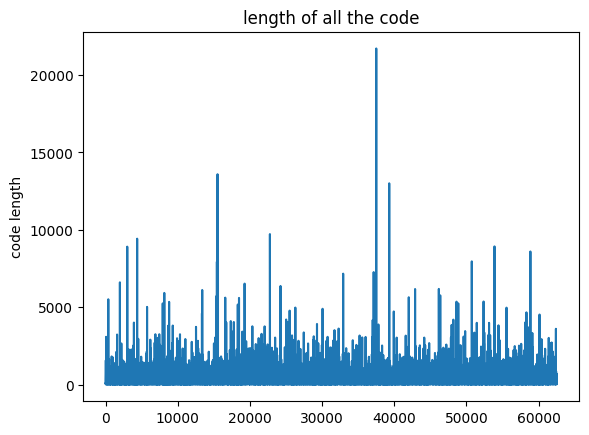

In [157]:
# plot all the code lengths

plt.plot(code_lengths)
plt.title("length of all the code")
plt.ylabel("code length")
plt.show()

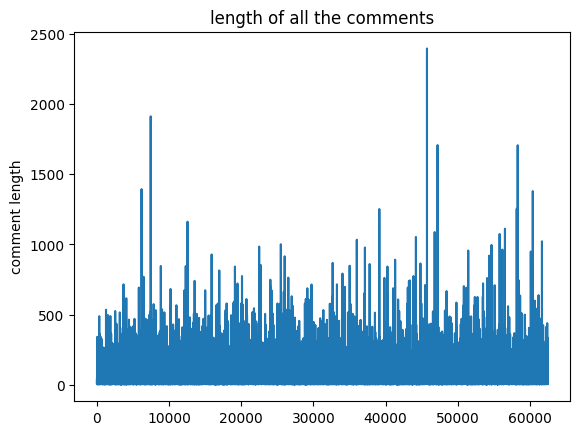

In [158]:
# plot all comment lengths

plt.plot(cmt_lengths)
plt.title("length of all the comments")
plt.ylabel("comment length")
plt.show()

as we see from the above graph, its clear that we have some outliers.

In [159]:
# Outliers

code_outlier, cmt_outlier = int( np.quantile(code_lengths, 0.90) ), int( np.quantile(cmt_lengths, 0.90)  )

code_outlier, cmt_outlier

(442, 91)

In [160]:
# add a piece of comment to code

np.mean( cmt_lengths )

41.253240518482954

In [161]:
# lets only consider the average length of the code and comment

# code_max_length, cmt_max_length =  256  ,  64      # "int(np.average(code_lengths))", int(np.average(cmt_lengths))
code_max_length = int(np.average(code_lengths))
cmt_max_length = int(np.average(cmt_lengths))
code_max_length, cmt_max_length

(211, 41)

In [162]:
# drop all the records that are greater than 256

long_code_index = [ i  for i, length in  enumerate( code_lengths ) if length > code_max_length ]

# drop all the recodrs in the index
train.drop(index = long_code_index, inplace = True)

# reset index
train = train.reset_index().drop(labels = 'index', axis = 1)


# drop all the records that are greater than 64
cmt_lengths = [ len( tokenizer.encode( comment, add_special_tokens= False ) ) for comment in train.docstring.values ]

long_cmt_index = [ i  for i, length in  enumerate( cmt_lengths ) if length > cmt_max_length ]

# drop all the recodrs in the index
train.drop(index = long_cmt_index, inplace = True)

train.shape, valid.shape, test.shape

((35519, 2), (14880, 2), (15537, 2))

In [163]:
# let us tokenize the data

BATCH_SIZE = 16


# To tokenize the code
def code_tokenizer(data : list):
    """
    input  :  list of code to be tokenized
    output :  input_ids and attention_mask tensor of type long
    """

    input_ids = []
    attention_mask = []

    for str in data:
        encoded = tokenizer.encode_plus( text= str , max_length= code_max_length, padding= 'max_length', truncation= True)
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])


    # covert the input ids and the attention mask to type tensor
    input_ids = torch.LongTensor(input_ids)
    attention_mask = torch.LongTensor(attention_mask)

    print(f"shape of the code input_ids -> {input_ids.shape}")
    print(f"shape of the code attention_mask -> {attention_mask.shape}")

    return input_ids, attention_mask


# let us tokenize docstring
def comment_tokenizer(data : list):
    """
    input  :  list of comment to be tokenized
    output :  input_ids and attention_mask tensor of type long
    """

    input_ids = []
    attention_mask = []

    for str in data:
        encoded = tokenizer.encode_plus( text= str , max_length= cmt_max_length, padding= 'max_length', truncation= True)
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])


    # covert the input ids and the attention mask to type tensor
    input_ids = torch.LongTensor(input_ids)
    attention_mask = torch.LongTensor(attention_mask)

    print(f"shape of the comment input_ids -> {input_ids.shape}")
    print(f"shape of the comment attention_mask -> {attention_mask.shape}")

    return input_ids, attention_mask


# creating a dataloader
# def make_data_loader(data : pd.DataFrame ) -> torch.utils.data.DataLoader2 :
def make_data_loader(data : pd.DataFrame ) -> torch.utils.data.DataLoader :
    """
    input  : pandas data frame of code docstring pair
    output : DataLaoder that has src_input_ids, src_attention_mask, tgt_input_ids, tgt_attention_mask
    """

    assert 'code' in test.columns , "rename the function column name to code "
    assert 'docstring' in test.columns , "rename the description column name to docstring "

    SRC_input_ids, SRC_attention_mask  = code_tokenizer(data.code.values)          # reurns input ids and attention mask of both source  -> shape [N, S]
    TGT_input_ids, TGT_attention_mask  = comment_tokenizer(data.docstring.values) # reurns input ids and attention mask of both source  -> shape [N, T]

    data = torch.utils.data.TensorDataset( SRC_input_ids, SRC_attention_mask, TGT_input_ids, TGT_attention_mask ) # has four values in one variable

    sampler =  torch.utils.data.RandomSampler(data)

    data_loader = torch.utils.data.DataLoader(dataset= data, batch_size= BATCH_SIZE, num_workers= 3, drop_last=True, sampler= sampler) # shape [N, S] -> [batchsize, sequence length]

    return data_loader

In [164]:
# Function call to create a data loader for thge model

print("For train data")
Train = make_data_loader(train)

For train data
shape of the code input_ids -> torch.Size([35519, 211])
shape of the code attention_mask -> torch.Size([35519, 211])
shape of the comment input_ids -> torch.Size([35519, 41])
shape of the comment attention_mask -> torch.Size([35519, 41])


In [165]:
print("For validation data")
Valid = make_data_loader(valid)

For validation data
shape of the code input_ids -> torch.Size([14880, 211])
shape of the code attention_mask -> torch.Size([14880, 211])
shape of the comment input_ids -> torch.Size([14880, 41])
shape of the comment attention_mask -> torch.Size([14880, 41])


In [166]:
print("For test data")
Test = make_data_loader(test)

For test data
shape of the code input_ids -> torch.Size([15537, 211])
shape of the code attention_mask -> torch.Size([15537, 211])
shape of the comment input_ids -> torch.Size([15537, 41])
shape of the comment attention_mask -> torch.Size([15537, 41])


## Develop model

In [167]:
class Beam(object):
    def __init__(self, size,sos,eos):

        """
        @article{DBLP:journals/corr/abs-2102-04664,
          author    = {Shuai Lu and
                       Daya Guo and
                       Shuo Ren and
                       Junjie Huang and
                       Alexey Svyatkovskiy and
                       Ambrosio Blanco and
                       Colin B. Clement and
                       Dawn Drain and
                       Daxin Jiang and
                       Duyu Tang and
                       Ge Li and
                       Lidong Zhou and
                       Linjun Shou and
                       Long Zhou and
                       Michele Tufano and
                       Ming Gong and
                       Ming Zhou and
                       Nan Duan and
                       Neel Sundaresan and
                       Shao Kun Deng and
                       Shengyu Fu and
                       Shujie Liu},
          title     = {CodeXGLUE: {A} Machine Learning Benchmark Dataset for Code Understanding
                       and Generation},
          journal   = {CoRR},
          volume    = {abs/2102.04664},
          year      = {2021}
        }
        """
        self.size = size
        self.tt = torch.cuda
        # The score for each translation on the beam.
        self.scores = self.tt.FloatTensor(size).zero_()
        # The backpointers at each time-step.
        self.prevKs = []
        # The outputs at each time-step.
        self.nextYs = [self.tt.LongTensor(size)
                       .fill_(0)]
        self.nextYs[0][0] = sos
        # Has EOS topped the beam yet.
        self._eos = eos
        self.eosTop = False
        # Time and k pair for finished.
        self.finished = []

    def getCurrentState(self):
        "Get the outputs for the current timestep."
        batch = self.tt.LongTensor(self.nextYs[-1]).view(-1, 1)
        return batch

    def getCurrentOrigin(self):
        "Get the backpointers for the current timestep."
        return self.prevKs[-1]

    def advance(self, wordLk):
        """
        Given prob over words for every last beam `wordLk` and attention
        `attnOut`: Compute and update the beam search.
        Parameters:
        * `wordLk`- probs of advancing from the last step (K x words)
        * `attnOut`- attention at the last step
        Returns: True if beam search is complete.
        """
        numWords = wordLk.size(1)

        # Sum the previous scores.
        if len(self.prevKs) > 0:
            beamLk = wordLk + self.scores.unsqueeze(1).expand_as(wordLk)

            # Don't let EOS have children.
            for i in range(self.nextYs[-1].size(0)):
                if self.nextYs[-1][i] == self._eos:
                    beamLk[i] = -1e20
        else:
            beamLk = wordLk[0]
        flatBeamLk = beamLk.view(-1)
        bestScores, bestScoresId = flatBeamLk.topk(self.size, 0, True, True)

        self.scores = bestScores

        # bestScoresId is flattened beam x word array, so calculate which
        # word and beam each score came from
        prevK = bestScoresId // numWords
        self.prevKs.append(prevK)
        self.nextYs.append((bestScoresId - prevK * numWords))


        for i in range(self.nextYs[-1].size(0)):
            if self.nextYs[-1][i] == self._eos:
                s = self.scores[i]
                self.finished.append((s, len(self.nextYs) - 1, i))

        # End condition is when top-of-beam is EOS and no global score.
        if self.nextYs[-1][0] == self._eos:
            self.eosTop = True

    def done(self):
        return self.eosTop and len(self.finished) >=self.size

    def getFinal(self):
        if len(self.finished) == 0:
            self.finished.append((self.scores[0], len(self.nextYs) - 1, 0))
        self.finished.sort(key=lambda a: -a[0])
        if len(self.finished) != self.size:
            unfinished=[]
            for i in range(self.nextYs[-1].size(0)):
                if self.nextYs[-1][i] != self._eos:
                    s = self.scores[i]
                    unfinished.append((s, len(self.nextYs) - 1, i))
            unfinished.sort(key=lambda a: -a[0])
            self.finished+=unfinished[:self.size-len(self.finished)]
        return self.finished[:self.size]

    def getHyp(self, beam_res):
        """
        Walk back to construct the full hypothesis.
        """
        hyps=[]
        for _,timestep, k in beam_res:
            hyp = []
            for j in range(len(self.prevKs[:timestep]) - 1, -1, -1):
                hyp.append(self.nextYs[j+1][k])
                k = self.prevKs[j][k]
            hyps.append(hyp[::-1])
        return hyps

    def buildTargetTokens(self, preds):
        sentence=[]
        for pred in preds:
            tokens = []
            for tok in pred:
                if tok==self._eos:
                    break
                tokens.append(tok)
            sentence.append(tokens)
        return sentence

In [168]:
class Code_Comment_Generator(pl.LightningModule):

    def __init__(self, encoder, decoder, d_model, src_vocab_size, tgt_vocab_Size, pad_idx, dropout, src_max_length, tgt_max_length, config, lr, epoch, tokenizer ):

        super(Code_Comment_Generator, self).__init__()


        self.d_model = d_model
        self.pad_idx = pad_idx
        self.lr = lr
        self.epoch = epoch
        self.tgt_max_length = tgt_max_length #
        self.beam_size = 10
        self.sos_id = 0
        self.eos_id =2
        self.tokenizer = tokenizer

        self.test_cases = []
        self.eval_counter = 0

        # pretrained config
        self.config = config

        # Roberta Encoder  layer
        self.encoder = encoder

        # Decoder Transformers
        self.decoder = decoder


        # Register buffer
        self.register_buffer("bias", torch.tril(torch.ones(2048, 2048))) # This is typically used to register a buffer that should not to be considered a model parameter.

        # dense layers
        self.dense_layer = nn.Linear(in_features= self.d_model,
                                out_features= self.d_model)


        # generator
        self.generator = nn.Linear(in_features= self.d_model,
                                out_features= tgt_vocab_Size,  bias=False)

        self.dropout = nn.Dropout(p=dropout)

        # final activation
        self.log_softmax = nn.LogSoftmax(dim= -1)

        # sharing weights between the encoder and the decoder
        self.share_weights()



    def share_weights(self):
        """
            This is to ensure we are sharing weights between the encoder and fianl dense layer
        """

        if self.config.torchscript:
            self.generator.weight = nn.Parameter( data =  self.encoder.embeddings.word_embeddings.weight.clone())

        else:
            self.generator.weight = self.encoder.embeddings.word_embeddings.weight


    def forward(self, src = None, src_key_padding_mask= None, tgt= None, tgt_key_padding_mask= None):
        """
        input  : source and taget tokens and attention mask
        output : logits

        """


        # encoder output, this gives us the context vector which is present in the last decoder layer

        encoder_output = self.encoder(src, attention_mask = src_key_padding_mask )[0]# considering the output of the last encoder layer  : shape -> torch.Size([32, 212, 768]) -> [N,S,E]
        encoder_output = encoder_output.permute([1,0,2]).contiguous() # rearanging tensor to shape -> torch.Size([212,32,768]) -> [S,N,E]

        if tgt is not None:

          tgt_mask = -1e4 *(1-self.bias[:tgt.shape[1],:tgt.shape[1]]).to(device= device) # shape -> trg_mask > torch.Size([42, 42])

          # encode the target embeddings
          tgt_embedding = self.encoder.embeddings(tgt)                    # shape: torch.Size([32, 42, 768]) -> [N, T, E]
          tgt_embedding = tgt_embedding.permute([1,0,2]).contiguous()     # shape: torch.Size([42, 32, 768]) -> [T, N, E]

          # memeory key padding mask
          memory_key_padding_mask = (1-src_key_padding_mask).bool()      # shape : torch.Size([32, 212])     -> [N, E]


          # output of the decoder
          output = self.decoder(tgt = tgt_embedding,
                                  memory = encoder_output,
                                  tgt_mask = tgt_mask,
                                  memory_key_padding_mask = memory_key_padding_mask )               # torch.Size([42, 32, 768]) -> T, N, E




          output =    torch.tanh( self.dropout(   self.dense_layer(output)  ) ).permute([1,0,2]).contiguous()  # activation + FC_1         # torch.Size([42, 32, 768])  -> T, N, E

          output =  self.generator(output)                    # output shape :- torch.Size([42, 32, 50265]) -> T, N, TGT_Vocb_size


          # calculate loss
          active_loss = tgt_key_padding_mask[: , 1: ].ne(0).view(-1) == 1      # shape -> torch.Size([1312]) N*(T-1)

          shift_logits = output[:, :-1, :].contiguous()                        # shape -> torch.Size([32, 41, 50265]) N, (T-1), TGT_vocab_size

          shift_labels = tgt[:, 1:].contiguous()                            # shape -> torch.Size([32, 41])        N, (T-1)


          # flatten the tokens and find the loss
          y_hat = shift_logits.view(-1, shift_logits.shape[-1])[active_loss]  # predicted value flatened
          y     = shift_labels.view(-1)[active_loss]                          # actual value flatten

          # find the cross entropy loss
          loss = F.cross_entropy(y_hat ,  y , ignore_index = self.pad_idx )

          # memory management
          del output
          torch.cuda.empty_cache()
          gc.collect()
          pl.utilities.memory.garbage_collection_cuda()
          # pl.utilities.memory.get_nvidia_gpu_stats()
          # pl.accelerators.cuda.get_nvidia_gpu_stats()
          pl.accelerators.cuda.get_nvidia_gpu_stats(device= torch.device("cuda:0"))


          return loss #, loss*active_loss.sum() # train loss, evaluation loss

        else:
          # prediction
          preds = []

          zero=torch.cuda.LongTensor(1).fill_(0)

          for i in range(src.shape[0]):

            context = encoder_output[:,i:i+1]

            context_mask = src_key_padding_mask[i:i+1,:]

            beam = Beam(self.beam_size, self.sos_id, self.eos_id) ####

            input_ids=beam.getCurrentState()

            context=context.repeat(1, self.beam_size,1)

            context_mask=context_mask.repeat(self.beam_size,1)

            for _ in range(self.tgt_max_length):   #######

              if beam.done():
                break

              tgt_mask=-1e4 *(1-self.bias[:input_ids.shape[1],:input_ids.shape[1]])

              tgt_embedding = self.encoder.embeddings(input_ids).permute([1,0,2]).contiguous()

              # memeory key padding mask
              memory_key_padding_mask = (1-context_mask).bool()      # shape : torch.Size([32, 212])     -> [N, E]


              # output of the decoder
              output = self.decoder(tgt = tgt_embedding,
                                      memory = context,
                                      tgt_mask = tgt_mask,
                                      memory_key_padding_mask = memory_key_padding_mask )               # torch.Size([42, 32, 768]) -> T, N, E




              output =  torch.tanh( self.dropout(   self.dense_layer(output)  ) ).permute([1,0,2]).contiguous()[:,-1,:]  # activation + FC_1         # torch.Size([42, 32, 768])  -> T, N, E

              output =  self.log_softmax( self.generator(output) ).data               # output shape :- torch.Size([42, 32, 50265]) -> T, N, TGT_Vocb_size

              beam.advance(output)

              input_ids.data.copy_(input_ids.data.index_select(0, beam.getCurrentOrigin()))
              input_ids=torch.cat((input_ids,beam.getCurrentState()),-1)

            hyp= beam.getHyp(beam.getFinal())
            pred=beam.buildTargetTokens(hyp)[:self.beam_size]
            pred=[torch.cat([x.view(-1) for x in p]+[zero]*(self.tgt_max_length -len(p))).view(1,-1) for p in pred]
            preds.append(torch.cat(pred,0).unsqueeze(0))

          preds=torch.cat(preds,0)

          del output
          del context
          torch.cuda.empty_cache()
          gc.collect()
          pl.utilities.memory.garbage_collection_cuda()
          # pl.utilities.memory.get_gpu_memory_map()
          pl.accelerators.cuda.get_nvidia_gpu_stats(device= torch.device("cuda:0"))

          return preds


    def training_step(self, batch, batch_indx):


        # train model
        self.train()

        # unrap and load all the trensors to device
        src, src_key_padding_mask, tgt, tgt_key_padding_mask = tuple( i.to(device) for i in batch)

        #returns loss
        Loss  = self( src, src_key_padding_mask, tgt, tgt_key_padding_mask )

        # log the loss
        self.log(name= "tran_loss", value= Loss, on_step= True, on_epoch=True, prog_bar= True, logger= True)

        # memory management
        gc.collect()
        pl.utilities.memory.garbage_collection_cuda()
        # pl.utilities.memory.get_gpu_memory_map()
        pl.accelerators.cuda.get_nvidia_gpu_stats(device= torch.device("cuda:0"))

        return Loss

    def validation_step(self, batch, batch_indx):


        # evaluate model
        self.eval()

        if self.eval_counter == 400 : # self.train_dataloader().batch_size

          code = " def search_features(self, search): if isinstance(search, string_types): search = [search] search = [s.replace('*', '.*') for s in search] cols = list(self.data.columns) results = [] for s in search: results.extend([f for f in cols if re.match(s + '$', f)]) return list(set(results)) "
          doc = "returns all features that match any of the elements in the input list."

          print(f"generated cmt : {self.generate_comment(code) }")
          print(f"original cmt : {doc}")

          self.test_cases.append(self.generate_comment(code))

          self.eval_counter = 0


        self.eval_counter += 1

        # unrap and load all the trensors to device
        src, src_key_padding_mask, tgt, tgt_key_padding_mask = tuple( i.to(device) for i in batch)

        #returns loss
        Loss  = self( src, src_key_padding_mask, tgt, tgt_key_padding_mask )


        # log the loss
        self.log(name= "validation_loss", value= Loss, on_step= True, on_epoch=True, prog_bar= True, logger= True)

        # memory management
        gc.collect()
        pl.utilities.memory.garbage_collection_cuda()
        pl.accelerators.cuda.get_nvidia_gpu_stats(device= torch.device("cuda:0"))

        return Loss


    def configure_optimizers(self):


        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']

        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': 0.0 },
            {'params': [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr = self.lr , eps= 1e-8 )

        nn.utils.clip_grad_norm_(self.parameters(), 1.0)

        torch.autograd.set_detect_anomaly(True)

        lr_scheduler = {
            'scheduler' : transformers.get_linear_schedule_with_warmup(optimizer= optimizer, num_warmup_steps = 5000, num_training_steps= self.epoch * len(Test)  ),
            'interval'  : "step",
            'frequency' : 1,
            'monitor'   : "validation_loss",
        }



        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def train_dataloader(self):

      return  Train

    def val_dataloader(self):

      return Valid


    def generate_comment(self, code):
      """
      input : single code string
      output : Generated comment
      """

      tokenized = self.tokenizer.encode_plus(code, max_length= 256, padding='max_length', return_attention_mask= True, truncation= True )

      src = torch.LongTensor(tokenized['input_ids'] ).unsqueeze(1).reshape(1,-1).to(device)
      src_key_padding_mask = torch.LongTensor(tokenized['attention_mask'] ).unsqueeze(1).reshape(1,-1).to(device)

      gen_cmt = []

      preds = self(src, src_key_padding_mask)

      for pred in preds:
        t  = pred[0].cpu().numpy()
        t=list(t)
        if 0 in t:
          t=t[:t.index(0)]
        text = self.tokenizer.decode(t,clean_up_tokenization_spaces=False)

        gen_cmt.append(text)

      return gen_cmt


In [169]:
# log in to weight and bias

wandb.login()

# !wandb login --relogin. # eff91dd48ca6e7c55dfef9359e810cf3747cd6a2

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [170]:
!pip install --upgrade pytorch-lightning

In [171]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger


In [172]:
#pretrained configuration
config = transformers.RobertaConfig.from_pretrained("microsoft/codebert-base")

d_model = config.hidden_size
src_vocab_size = tokenizer.vocab_size
tgt_vocab_Size = tokenizer.vocab_size
pad_idx = tokenizer.pad_token_id
dropout = 0.5
src_max_length = code_max_length
tgt_max_length = cmt_max_length
epoch = 5
lr = 5e-5

# object of seq2seql model
# seq2seql = Seq2Seq(d_model, src_vocab_size, tgt_vocab_Size, pad_idx, dropout, src_max_length, tgt_max_length, encoder, decoder, config ).to(device = device)

# Roberta Encoder  layer
encoder = transformers.RobertaModel.from_pretrained(pretrained_model_name_or_path= "microsoft/codebert-base", config =  config )


# Decoder Transformers
decoder_layer = torch.nn.TransformerDecoderLayer(d_model= config.hidden_size, nhead= config.num_attention_heads)
decoder = torch.nn.TransformerDecoder(decoder_layer= decoder_layer, num_layers= 6)

# lightning model
model = Code_Comment_Generator(encoder, decoder, d_model, src_vocab_size, tgt_vocab_Size, pad_idx, dropout, src_max_length, tgt_max_length, config, lr, epoch, tokenizer).to(device)


In [173]:
# lightning configuration

lr_monitor = LearningRateMonitor(logging_interval = "step" )

early_stopping = EarlyStopping(monitor= "validation_loss",
                               min_delta = 0.001,
                               patience= 5,
                               strict= True,
                               verbose= True,
                               mode = 'min')

model_checkpoint = ModelCheckpoint(dirpath= f"saved_python_model_weights/",
                                   save_last=True,
                                   monitor="validation_loss",
                                   save_on_train_epoch_end = True,
                                   mode="min",
                                   save_top_k = 0)


wandb_logger = WandbLogger(name= f'Transformers_for_python_Code_Comment_Generator_code_size_256_with_code_comment',
                           project='Desertation_Final_extras',
                           log_model= True,
                           save_dir = f"./saved_python_model_weights/" )

wandb_logger.watch(model, log="all", log_graph=True)

trainer = Trainer(callbacks= [lr_monitor, early_stopping, model_checkpoint],
                  devices= 1 ,
                  gradient_clip_algorithm= 'norm',
                  accelerator='gpu',
                  enable_progress_bar= True,
                  default_root_dir = f"./saved_python_model_weights/default_root_dir/",
                  max_epochs = epoch ,
                  logger = wandb_logger,
                  strategy="auto" ,
                  precision=16)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [174]:
from pytorch_lightning.accelerators.cuda import get_nvidia_gpu_stats

In [175]:
import time

In [176]:
start = time.time()
trainer.fit(model)
training_time=time.time()-start

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params
---------------------------------------------------
0 | encoder     | RobertaModel       | 124 M 
1 | decoder     | TransformerDecoder | 47.3 M
2 | dense_layer | Linear             | 590 K 
3 | generator   | Linear             | 38.6 M
4 | dropout     | Dropout            | 0     
5 | log_softmax | LogSoftmax         | 0     
---------------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
690.014   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

generated cmt : ['returns a list of the list of the list of the list of the list of the list of the list.']
original cmt : returns all features that match any of the elements in the input list.
generated cmt : ['returns a list of the list of the list of the list of the list of the list of the list.']
original cmt : returns all features that match any of the elements in the input list.


INFO:pytorch_lightning.callbacks.early_stopping:Metric validation_loss improved. New best score: 6.290


Validation: 0it [00:00, ?it/s]

generated cmt : ['returns a list of the given model.']
original cmt : returns all features that match any of the elements in the input list.
generated cmt : ['returns a list of the given model.']
original cmt : returns all features that match any of the elements in the input list.


INFO:pytorch_lightning.callbacks.early_stopping:Metric validation_loss improved by 0.900 >= min_delta = 0.001. New best score: 5.390


Validation: 0it [00:00, ?it/s]

generated cmt : ['returns the list of features in the given list.']
original cmt : returns all features that match any of the elements in the input list.
generated cmt : ['returns the list of features in the given list.']
original cmt : returns all features that match any of the elements in the input list.


INFO:pytorch_lightning.callbacks.early_stopping:Metric validation_loss improved by 0.041 >= min_delta = 0.001. New best score: 5.349


Validation: 0it [00:00, ?it/s]

generated cmt : ['returns the list of features in the given list.']
original cmt : returns all features that match any of the elements in the input list.
generated cmt : ['returns the list of features in the given list.']
original cmt : returns all features that match any of the elements in the input list.
generated cmt : ['returns the list of features in the given list.']
original cmt : returns all features that match any of the elements in the input list.


Validation: 0it [00:00, ?it/s]

generated cmt : ['returns the list of features in the given list.']
original cmt : returns all features that match any of the elements in the input list.
generated cmt : ['returns the list of features in the given list.']
original cmt : returns all features that match any of the elements in the input list.


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
"""
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,600000000)
"""

'\nfunction ClickConnect(){\nconsole.log("Working");\ndocument.querySelector("colab-toolbar-button#connect").click()\n}\nsetInterval(ClickConnect,600000000)\n'

In [177]:
# Specify a path to save to
PATH = '/content/drive/MyDrive/Data/code_search_net/output/' + "model-batch-16.pt"

# Save
torch.save(model.state_dict(), PATH)

In [178]:
# Load
device = torch.device('cuda:0')

In [179]:
#pretrained configuration
config = transformers.RobertaConfig.from_pretrained("microsoft/codebert-base")

d_model = config.hidden_size
src_vocab_size = tokenizer.vocab_size
tgt_vocab_Size = tokenizer.vocab_size
pad_idx = tokenizer.pad_token_id
dropout = 0.5
src_max_length = code_max_length
tgt_max_length = cmt_max_length
epoch = 1000
lr = 5e-5

# Roberta Encoder  layer
encoder = transformers.RobertaModel.from_pretrained(pretrained_model_name_or_path= "microsoft/codebert-base", config =  config )


# Decoder Transformers
decoder_layer = torch.nn.TransformerDecoderLayer(d_model= config.hidden_size, nhead= config.num_attention_heads)
decoder = torch.nn.TransformerDecoder(decoder_layer= decoder_layer, num_layers= 6)

# lightning model
modelNew = Code_Comment_Generator(encoder, decoder, d_model, src_vocab_size, tgt_vocab_Size, pad_idx, dropout, src_max_length, tgt_max_length, config, lr, epoch, tokenizer).to(device)

modelNew.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [180]:
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import CrossEncoder

In [183]:
# cross encoder to check sentence similarity
check_similarity = CrossEncoder('cross-encoder/stsb-roberta-base')

In [184]:
def code_pre_proceeing(code):
    """
    input  : unprocessed code
    output : clean code
    """

    # remove any html tag
    # code = re.sub(r"<.?span[^>]*>|<.?code[^>]*>|<.?p[^>]*>|<.?hr[^>]*>|<.?h[1-3][^>]*>|<.?a[^>]*>|<.?b[^>]*>|<.?blockquote[^>]*>|<.?del[^>]*>|<.?dd[^>]*>|<.?dl[^>]*>|<.?dt[^>]*>|<.?em[^>]*>|<.?i[^>]*>|<.?img[^>]*>|<.?kbd[^>]*>|<.?li[^>]*>|<.?ol[^>]*>|<.?pre[^>]*>|<.?s[^>]*>|<.?sup[^>]*>|<.?sub[^>]*>|<.?strong[^>]*>|<.?strike[^>]*>|<.?ul[^>]*>|<.?br[^>]*>", "", code)

    # remove extra spaces and to lower cases
    code = ' '.join(code.split()).lower()

    return code

In [185]:
# function to automatically generate comment

def generated_comment_report(code, actual_cmt = None ):
    """
    input: code snippet that requires comment to be generated
    output: Generated comments
    """

    # generate comment
    generated_comment = modelNew.generate_comment(code_pre_proceeing(code))[0]

    if actual_cmt is None:
      print( f" Generated Comment  :  \n { generated_comment }" )
    else:
      print( f" code : \n { code } " )
      print("\n")
      print( f" True comment : \n { actual_cmt  }" )
      print("\n")
      print( f" Generated Comment  :  \n { generated_comment }" )
      print("\n")

      # calculate blue score
      blue_score = sentence_bleu([actual_cmt.lower()], generated_comment)
      print(f"the blue score for generated comment is {blue_score}")
      print("\n")
      # calculate similarity
      similarity = np.average( check_similarity.predict([actual_cmt.lower(), generated_comment ] ) )
      print(f"the similarity between sentences  is {similarity}")

In [186]:
# randomly select a record to generate comments and compare them

idx = np.random.randint(test.shape[0])

code = test.code.values[idx]
cmt = test.docstring.values[idx].split('\n')[0]

result = generated_comment_report(code, cmt)
result

 code : 
 def write_unzipped(self, destination): """""" for name, buffer in self._buffers.items(): with open(os.path.join(destination, '{}.txt'.format(name)), 'w', encoding='utf-8') as file: file.write(buffer.getvalue()) for name, path in self._files.items(): shutil.copy(path, os.path.join(destination, name)) 


 True comment : 
 write gtfs text files in the given path.


 Generated Comment  :  
 write a stream into a file.


the blue score for generated comment is 0.24057029356071943


the similarity between sentences  is 0.42782703042030334


In [187]:
with open(f"/content/drive/MyDrive/Data/code_search_net/output/output-{len(train.index)}-samples-{BATCH_SIZE}-batch-{epoch}-epoch-{lr}-learningrate.txt", "a") as f:
    print(result, file=f)
    print(f"Training time: {training_time} secs", file=f)

In [193]:
codetemp = """import pandas as pd \n df = pd.read_csv('file.csv')"""
cmttemp = 'load data'
result = generated_comment_report(codetemp, cmttemp)
result

 code : 
 import pandas as pd 
 df = pd.read_csv('file.csv') 


 True comment : 
 load data


 Generated Comment  :  
 read table data.


the blue score for generated comment is 0.30620490882364887


the similarity between sentences  is 0.48618772625923157
